# Introduction
This notebook evaluates a trained model (CNN-LSTM) on normalized data, using Monte Carlo Dropout to compute predictions with uncertainty intervals. The notebook allows for testing on either a sample subset or the entire dataset.

### Import Necessary Libraries

In [98]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from model import CNN_LSTM
from monte_carlo_dropout import MonteCarloDropoutModel
from dataset import WebcamDataset  # Replace with your dataset class
from torch.utils.data import DataLoader, Subset

In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define the `evaluate_model` Function
The evaluate_model function evaluates the model either on the entire dataset or a subset, returning predictions, confidence intervals, and ground truth values.


In [100]:
def evaluate_model(
    model_path,
    normalized_labels_file,
    normalized_images_file,
    device,
    evaluate_sample=False,
    num_samples=100,
    batch_size=32,
    num_mc_samples=50,
):
    """
    Evaluate the model on either a subset of the data or the entire dataset.
    
    Args:
        model_path (str): Path to the trained model checkpoint.
        normalized_labels_file (str): Path to the normalized labels file.
        normalized_images_file (str): Path to the normalized images file.
        device (torch.device): The device to run the evaluation (e.g., 'cuda' or 'cpu').
        evaluate_sample (bool): If True, evaluates only a subset of the data for quick testing.
        num_samples (int): Number of samples to evaluate if evaluate_sample=True.
        batch_size (int): Batch size for the DataLoader.
        num_mc_samples (int): Number of Monte Carlo Dropout passes.

    Returns:
        tuple: (predictions, lower_bounds, upper_bounds, ground_truths)
    """
    # Load the model
    base_model = CNN_LSTM()  # Base model
    wrapper_model = MonteCarloDropoutModel(base_model, num_samples=num_mc_samples)

    # Load the checkpoint and strip prefix
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = {key.replace("module.base_model.", ""): value for key, value in checkpoint["MODEL_STATE"].items()}
    wrapper_model.base_model.load_state_dict(state_dict)
    wrapper_model.to(device)

    # Load the dataset
    val_dataset = WebcamDataset(
        images_path=normalized_images_file, ghi_values_path=normalized_labels_file
    )

    # Subset for quick evaluation if evaluate_sample is True
    if evaluate_sample:
        val_dataset = Subset(val_dataset, range(0, num_samples))

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Perform evaluation
    wrapper_model.eval()
    predictions, lower_bounds, upper_bounds = [], [], []

    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            mean_prediction, lower_bound, upper_bound = wrapper_model(inputs)
            predictions.extend(mean_prediction.squeeze(-1).cpu().numpy())
            lower_bounds.extend(lower_bound.squeeze(-1).cpu().numpy())
            upper_bounds.extend(upper_bound.squeeze(-1).cpu().numpy())

    predictions = np.array(predictions)
    lower_bounds = np.array(lower_bounds)
    upper_bounds = np.array(upper_bounds)

    # Load ground truth
    ground_truths = np.load(normalized_labels_file)
    ground_truths = ground_truths[:len(predictions)]  # Ensure lengths match

    return predictions, lower_bounds, upper_bounds, ground_truths


### Set Up Device and File Paths
This cell sets up the device (CPU or GPU) and specifies file paths for the model and normalized data.

In [101]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to model and data files
model_path = "results/80epochs_5samples/model.pt"
normalized_labels_file = "data/normalized_labels_val.npy"
normalized_images_file = "data/normalized_X_BC_val.npy"


### Define Plotting Function
This function takes predictions, ground truths, and uncertainty intervals as inputs and plots the results. It can be reused for both sample-based and full-dataset evaluations.

In [102]:
def plot_predictions_with_uncertainty(predictions, lower_bounds, upper_bounds, ground_truths, title="Predictions with 95% Confidence Interval"):
    """
    Plot predictions along with 95% confidence intervals and ground truth values.

    Args:
        predictions (np.array): Model predictions.
        lower_bounds (np.array): Lower bounds of the 95% confidence interval.
        upper_bounds (np.array): Upper bounds of the 95% confidence interval.
        ground_truths (np.array): Ground truth values.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truths, label="Ground Truth", color="red", linestyle="dashed")
    plt.plot(predictions, label="Predictions", color="blue")
    plt.fill_between(
        range(len(predictions)),
        lower_bounds,
        upper_bounds,
        color="blue",
        alpha=0.2,
        label="95% Confidence Interval",
    )
    plt.legend()
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("GHI Score")
    plt.show()


### Evaluate the Model
This cell calls the `evaluate_model` function to generate predictions and confidence intervals, and then uses the plotting function to visualize the results.

/var/folders/5x/09mb812944v2xvwj26_8vt240000gn/T/ipykernel_76048/1889410844.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_loca

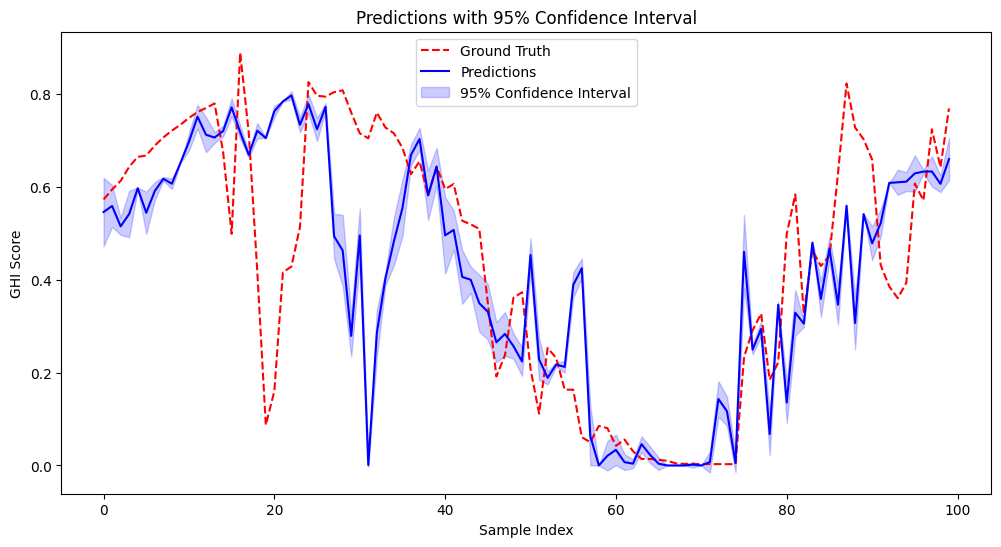

In [103]:
# Evaluate the model on a sample (or the full dataset by setting evaluate_sample=False)
predictions, lower_bounds, upper_bounds, ground_truths = evaluate_model(
    model_path,
    normalized_labels_file,
    normalized_images_file,
    device,
    evaluate_sample=True,  # Set to False to evaluate on the entire dataset
    num_samples=100,  # Number of samples for quick evaluation (ignored if evaluate_sample=False)
    batch_size=8,  # Smaller batch size for faster runtime
    num_mc_samples=10  # Reduced for quicker runtime; increase for more confidence
)

# Plot the results
plot_predictions_with_uncertainty(predictions, lower_bounds, upper_bounds, ground_truths)


### Evaluate on Entire Dataset
This cell runs the evaluation function on the entire dataset. It may take longer to run depending on the size of the dataset and the number of Monte Carlo samples.

/var/folders/5x/09mb812944v2xvwj26_8vt240000gn/T/ipykernel_76048/1889410844.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_loca

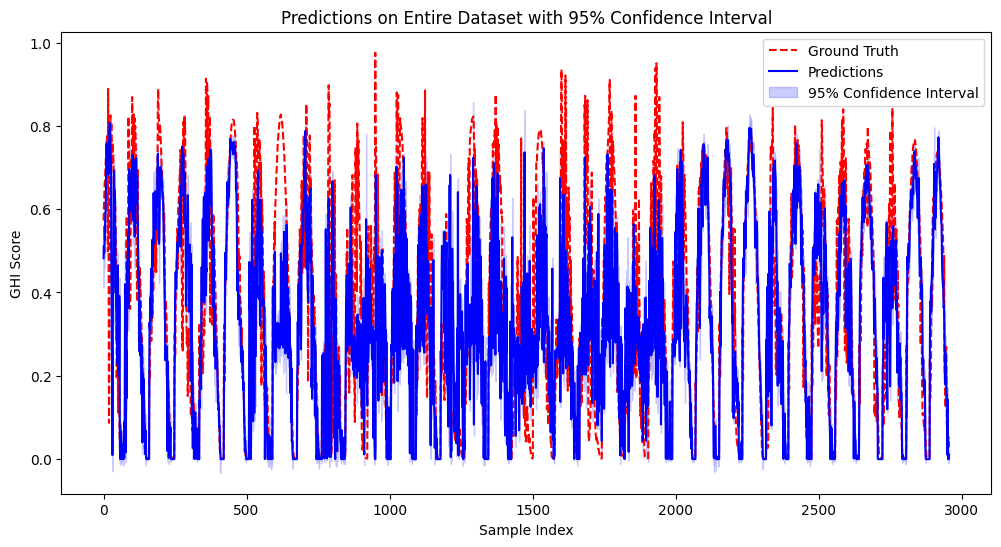

In [104]:
# Evaluate the model on the entire dataset
predictions_full, lower_bounds_full, upper_bounds_full, ground_truths_full = evaluate_model(
    model_path,
    normalized_labels_file,
    normalized_images_file,
    device,
    evaluate_sample=False,  # Set to False to evaluate on the entire dataset
    batch_size=32,  # Larger batch size for efficiency
    num_mc_samples=50  # Increased for better confidence intervals
)

# Plot the results for the entire dataset
plot_predictions_with_uncertainty(
    predictions_full,
    lower_bounds_full,
    upper_bounds_full,
    ground_truths_full,
    title="Predictions on Entire Dataset with 95% Confidence Interval"
)
